In [1]:
%run init_notebook.py

In [14]:
from src.utils import *
from src.processing import *

In [3]:
hhp = load_pd_df('hhp_processed.feather')

In [15]:
hhp.index.name = 'date_recorded'

In [25]:
pi = get_dt_index(load_pd_df('de_inf_prepro.csv'))
bei = load_pd_df('bei_data.feather')
mir = get_dt_index(load_pd_df('mir.csv'))
gdp = get_dt_index(load_pd_df('gdp.csv'))
ecb = get_dt_index(load_pd_df('ecb_tf.csv'))
pi_prog = get_dt_index(load_pd_df('infl_prognonsis.csv'))

In [17]:
# merge dfs

In [30]:
df = pd_join_dfs(
    [
        pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']],
        hhp[['pi_c_hhp_rm']],
        bei[['bei']],
        gdp[['gdp_cyc']],
        mir,
    ],    
    index_name='date_recorded'
)

In [73]:
sub = df[['pi_c_hhp_rm', 'bei']].dropna().drop_duplicates().copy()

In [74]:
# VAR

In [75]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from statsmodels.tsa.stattools import adfuller

<AxesSubplot: xlabel='date_recorded'>

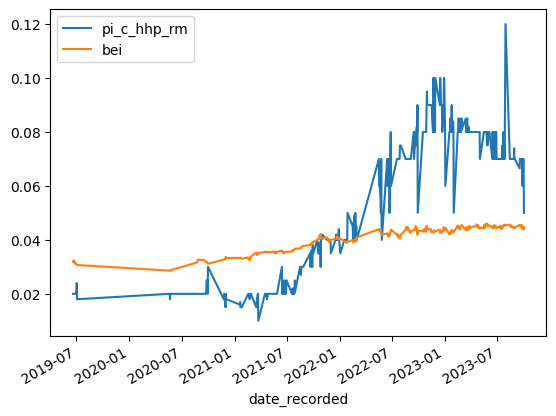

In [76]:
sub.plot()

In [77]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i])[1]}")

pi_c_hhp_rm ADF p-val: 0.628730835280499
bei ADF p-val: 0.051346324316309734


In [78]:
jtest = select_coint_rank(sub, -1, 15, method="trace", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          15.52          12.32
  1   2         0.1801          4.130
-------------------------------------


1

In [79]:
vecm = VECM(sub, coint_rank=jtest.rank).fit()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [80]:
vecm.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_c_hhp_rm,-0.4760,0.046,-10.370,0.000,-0.566,-0.386
L1.bei,1.0034,0.562,1.784,0.074,-0.099,2.105
,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_c_hhp_rm,0.0036,0.004,0.868,0.385,-0.005,0.012
L1.bei,-0.2138,0.051,-4.179,0.000,-0.314,-0.114
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0396,0.017,-2.379,0.017,-0.072,-0.007
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0017,0.002,-1.124,0.261,-0.005,0.001
,coef,std err,z,P>|z|,[0.025,0.975]


In [81]:
sub.columns

Index(['pi_c_hhp_rm', 'bei'], dtype='object')

In [83]:
vecm.test_granger_causality('bei', 'pi_c_hhp_rm', ).summary()

Test statistic,Critical value,p-value,df
0.8530,3.008,0.427,"(2, 722)"


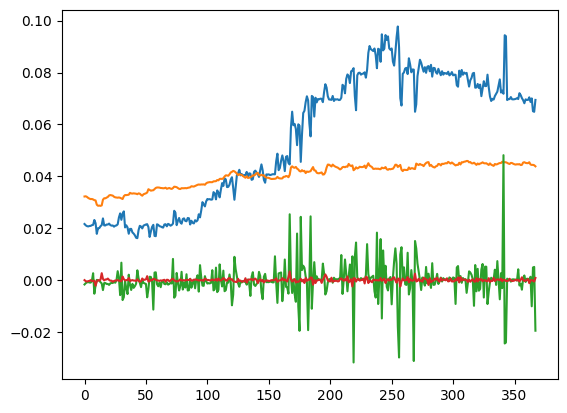

In [84]:
plt.plot(vecm.fittedvalues)
plt.plot(vecm.resid)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest, ttest_1samp

In [ ]:
plt.hist(vecm.resid)
;

In [ ]:
for i in range(vecm.resid.shape[1]):
    print("\n", i, acorr_ljungbox(vecm.resid[:, i], boxpierce=True, model_df=1))

In [ ]:
# VAR

In [ ]:
var = VAR(_).fit()

In [ ]:
var.summary()

In [ ]:
var.test_causality('hhp_r_d', 'pi_de_Y').summary()

In [ ]:
var.resid.plot()

In [ ]:
# attention model 1

In [8]:
# inflation

$$ a(s) = \lambda s + (1-\lambda)x^d \quad \lambda = \frac{\sigma_x}{\sigma_x + \sigma_{\epsilon}}$$

In [9]:
mod1 = pi[['pi_de', 'pi_de_estimate', 'pi_de_surprise']].copy()
std = mod1[['pi_de_estimate', 'pi_de_surprise']].rolling(12).std().dropna().apply(lambda x: x.values[0] / x.sum(), axis=1).rename('m')

In [10]:
mod1 = mod1.join(std)

In [11]:
mod1 = mod1.join(mod1.pi_de.rolling(24).mean().rename('pi_de_mean'))

In [12]:
mod1['pi_de_behav'] = mod1.m * mod1.pi_de + (1 - mod1.m) * mod1.pi_de_mean

<AxesSubplot: xlabel='date'>

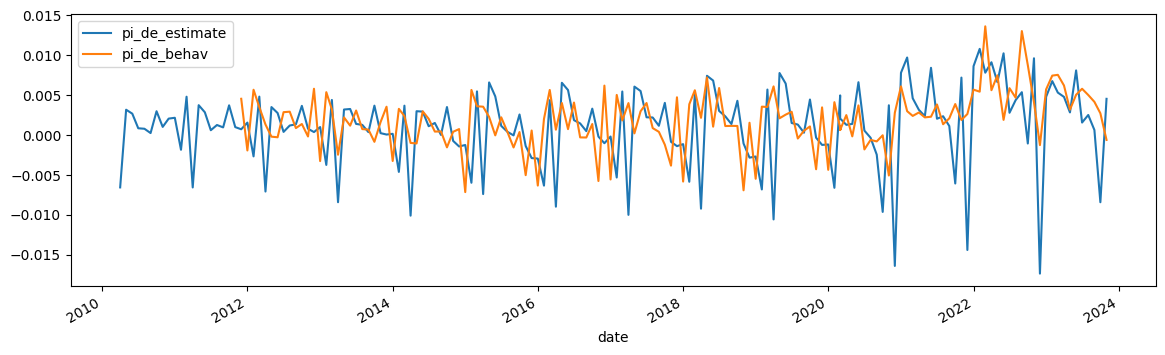

In [13]:
mod1[['pi_de_estimate', 'pi_de_behav']].plot(figsize=(14,4))